In [22]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from warnings import filterwarnings
filterwarnings('ignore')
from matplotlib import pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier as GBC
from xgboost import XGBClassifier as XGB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

rs = 42

In [2]:
! git clone https://github.com/dsreload/ml_3
data = pd.read_csv('ml_3/winequality-red.csv', sep = ';')
results = pd.DataFrame(columns = ['model', 'task', 'accuracy'])

Cloning into 'ml_3'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 13 (delta 2), reused 10 (delta 2), pack-reused 1 (from 1)
Receiving objects: 100% (13/13), 9.61 MiB | 7.41 MiB/s, done.
Resolving deltas: 100% (2/2), done.


https://archive.ics.uci.edu/ml/datasets/wine+quality

1.Разделите выборку на обучающую и тестовую в отношении 70%/30%, предварительно выделив целевую переменную (колонка 'quality').

In [37]:
x = data.loc[:,:'alcohol']
y = data['quality']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify = y)

2.Оцените качество на тестовой выборке по метрике accuracy для классификаторов:

DecisionTreeClassifier

BaggingClassifier со 100 деревьями

RandomForestClassifier со 100 деревьями

Сравните результаты и напишите какой вывод можно сделать.

In [38]:
clfs = [
    ('DecisionTreeClassifier', DecisionTreeClassifier(random_state=rs)),
    ('BaggingClassifier', BaggingClassifier(n_estimators=100, random_state=rs)),
    ('RandomForestClassifier', RandomForestClassifier(n_estimators=100, random_state=rs))
]

for el in enumerate(clfs):
    results.loc[el[0]] = [el[1][0], 'task2', el[1][1].fit(x_train, y_train).score(x_test, y_test)]

results # Ансамбль моделей дает лучшую точность, чем одно дерево решений, так как он меньше переобучен

,model,task,accuracy
5,GradientBoostingClassifier_CV,task5,0.631250
6,XGBClassifier_CV,task5,0.647917
7,LGBMClassifier,task6,0.547917
8,CatBoostClassifier,task6,0.560417
9,LGBMClassifier_CV,task7,0.675000
10,CatBoostClassifier_CV,task7,0.635417
12,Stacking default,task9,0.683333
13,Stacking,task10,0.691667
0,DecisionTreeClassifier,task2,0.600000
1,BaggingClassifier,task2,0.620833


3.Посчитайте качество на тестовой выборке по метрике accuracy для классификатора RandomForestClassifier, используя значения деревьев:
    
10, 50, 100, 200, далее с шагом 200 до 5000 деревьев.
Постройте график зависимости качества от числа деревьев.



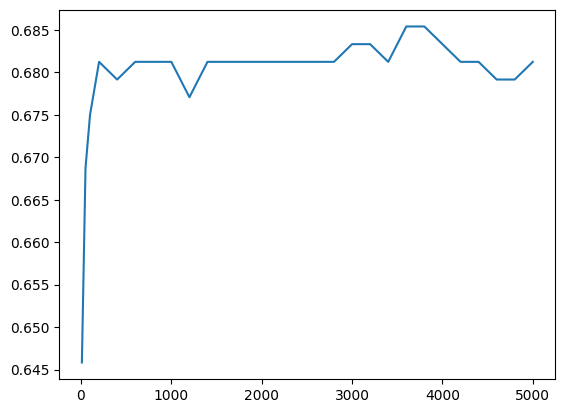

In [5]:
trees = [10, 50, 100] + [x for x in range(200, 5001, 200)]
res = {}
for x in trees:
    model = RandomForestClassifier(n_estimators=x, random_state=rs, n_jobs=-1).fit(x_train, y_train)
    res[x] = accuracy_score(y_test, model.predict(x_test))
plt.plot(res.keys(),res.values())
plt.show()

4.Обучите реализации градиентного бустинга с параметрами по умолчанию из библиотек sklearn и xgboost. Сравните значение метрики accuracy по cross_val_score

In [39]:
y_train = y_train.map({3: 0, 4: 1, 5: 2, 6: 3, 7: 4, 8: 5})
y_test = y_test.map({3: 0, 4: 1, 5: 2, 6: 3, 7: 4, 8: 5})
clfs = [('GradientBoostingClassifier', GBC(random_state=rs)), ('XGBClassifier', XGB(random_state=rs))]
for el in enumerate(clfs, start = 3):
    el[1][1].fit(x_train, y_train)
    results.loc[el[0]] = [el[1][0], 'task4', np.mean(cross_val_score(el[1][1], x_test, y_test, scoring="accuracy",cv=3))]

5.Подберите оптимальные параметры этих алгоритмов с помощью GridSearchCV(cv=3).
Параметры для оптимизации:

скорость обучения

количество деревьев

глубина деревьев

Сравните значение метрики accuracy. Выведите лучшие параметры алгоритмов.

In [20]:
gbc = {'learning_rate': [0.2, 0.25, 0.3],'n_estimators': [5, 6, 7],'max_depth': [6, 7, 8]}
xgb = {'learning_rate': [0.24, 0.25, 0.3, 0.35, 0.4],'n_estimators': [24, 26, 29, 32],'max_depth': [8, 9, 11]}
clfs = [('GradientBoostingClassifier_CV', GBC(criterion='squared_error', random_state=rs), gbc),
    ('XGBClassifier_CV', XGB(colsample_bytree=0.3333, eval_metric='mlogloss', min_child_weight=1, random_state=rs, subsample=0.777, tree_method='hist'), xgb)]
for el in enumerate(clfs, start = 5):
    grid = GridSearchCV(el[1][1], el[1][2], scoring='accuracy', n_jobs=-1, cv=3)
    model = grid.fit(x_train, y_train)
    print(el[1][0], "GridSearchCV best params:", grid.best_params_)
    results.loc[el[0]] = [el[1][0], 'task5', model.score(x_test, y_test)]

GradientBoostingClassifier_CV GridSearchCV best params: {'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 7}
XGBClassifier_CV GridSearchCV best params: {'learning_rate': 0.25, 'max_depth': 9, 'n_estimators': 24}


6.Обучите реализации градиентного бустинга с параметрами по умолчанию из библиотек lightgbm и catboost. Сравните значение метрики accuracy по cross_val_score по всем четырем реализациям.

In [28]:
#!pip install catboost
from catboost import CatBoostClassifier

clfs = [('LGBMClassifier', LGBMClassifier(random_state=rs)), ('CatBoostClassifier', CatBoostClassifier(random_state=rs, verbose=False))]
for el in enumerate(clfs, start = 7):
    el[1][1].fit(x_train, y_train)
    results.loc[el[0]] = [el[1][0], 'task6', np.mean(cross_val_score(el[1][1], x_test, y_test, scoring="accuracy",cv=3))]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 995
[LightGBM] [Info] Number of data points in the train set: 1119, number of used features: 11
[LightGBM] [Info] Start training from score -5.074281
[LightGBM] [Info] Start training from score -3.409273
[LightGBM] [Info] Start training from score -0.852674
[LightGBM] [Info] Start training from score -0.919872
[LightGBM] [Info] Start training from score -2.085717
[LightGBM] [Info] Start training from score -4.455241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

7.Подберите оптимальные параметры для алгоритмов градиентного бустинга из библиотек lightgbm и catboost с теми же условиями.
Сравните значение метрики accuracy. Выведите лучшие параметры алгоритмов.

In [31]:
lgbm = {'learning_rate': [0.15, 0.2, 0.25],'n_estimators': [100, 150, 200, 250, 300, 350, 400],'max_depth': [4, 5, 6, 7, 8, 9]}
cat = {'learning_rate': [0.05, 0.1, 0.15],'n_estimators': [200],'max_depth': [8, 9, 10]}
clfs = [('LGBMClassifier_CV', LGBMClassifier(random_state=rs), lgbm),('CatBoostClassifier_CV', CatBoostClassifier(random_state=rs, verbose=False), cat)]
for el in enumerate(clfs, start = 9):
    grid = GridSearchCV(el[1][1], el[1][2], scoring='accuracy', n_jobs=-1, cv=3)
    model = grid.fit(x_train, y_train)
    print(el[1][0], "GridSearchCV best params:", grid.best_params_)
    results.loc[el[0]] = [el[1][0], 'task7', model.score(x_test, y_test)]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 995
[LightGBM] [Info] Number of data points in the train set: 1119, number of used features: 11
[LightGBM] [Info] Start training from score -5.074281
[LightGBM] [Info] Start training from score -3.409273
[LightGBM] [Info] Start training from score -0.852674
[LightGBM] [Info] Start training from score -0.919872
[LightGBM] [Info] Start training from score -2.085717
[LightGBM] [Info] Start training from score -4.455241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

8.Подберите оптимальные параметры алгоритма из библиотеки xgbost с помощью [optuna](https://github.com/optuna/optuna) . Параметры для оптимизации:

скорость обучения

количество деревьев

глубина деревьев

Сравните результат с поиском по сетке из sklearn. Выведите лучшие параметры алгоритма, найденные даным способом.

In [42]:
!pip install optuna
from xgboost import XGBClassifier
import optuna

def optim(trial):
    params = {'max_depth': trial.suggest_int('max_depth', 1, 9),'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),'n_estimators': trial.suggest_int('n_estimators', 50, 500),}
    y_pred_op = XGBClassifier(**params).fit(x_train, y_train).predict(x_test)
    return accuracy_score(y_test, y_pred_op)
modl = optuna.create_study(direction='maximize')
modl.optimize(optim, n_trials=50)
print(modl.best_trial.params)
best_xgb = XGBClassifier(**best_params_xgboost_optuna).fit(x_train, y_train)
acc_xgboost_optuna = cross_val_score(best_xgb, x_train, y_train, cv=3, scoring='accuracy').mean()

results.loc[11] = ['XGBClassifier_optuna', 'task8', acc_xgboost_optuna]

[I 2024-08-31 14:31:42,072] A new study created in memory with name: no-name-0d38572f-eaea-4ceb-9cc0-06fd6c458cb7
[I 2024-08-31 14:31:44,417] Trial 0 finished with value: 0.6395833333333333 and parameters: {'max_depth': 8, 'learning_rate': 0.47216955687747186, 'n_estimators': 493}. Best is trial 0 with value: 0.6395833333333333.
[I 2024-08-31 14:31:45,665] Trial 1 finished with value: 0.63125 and parameters: {'max_depth': 5, 'learning_rate': 0.5103972136247251, 'n_estimators': 335}. Best is trial 0 with value: 0.6395833333333333.
[I 2024-08-31 14:31:45,885] Trial 2 finished with value: 0.58125 and parameters: {'max_depth': 1, 'learning_rate': 0.21383629466867612, 'n_estimators': 123}. Best is trial 0 with value: 0.6395833333333333.
[I 2024-08-31 14:31:46,525] Trial 3 finished with value: 0.6333333333333333 and parameters: {'max_depth': 3, 'learning_rate': 0.13289605734933144, 'n_estimators': 171}. Best is trial 0 with value: 0.6395833333333333.
[I 2024-08-31 14:31:47,477] Trial 4 finis

{'max_depth': 8, 'learning_rate': 0.05359192425648539, 'n_estimators': 142}


9.Выведите качество по метрике accuracy стэкинга (StackingClassifier) 4-х алгоритмов с базовыми параметрами градиентного бустинга.

In [32]:
from sklearn.ensemble import StackingClassifier
estimators = [('GBC', GBC(random_state=rs)),('XGB', XGB(random_state=rs)),('LGBM', LGBMClassifier(random_state=rs)),('CatBoost', CatBoostClassifier(random_state=rs))]
stacking = StackingClassifier(estimators=estimators, cv=3, n_jobs=-1)
results.loc[12] = ['Stacking default', 'task9', accuracy_score(y_test, stacking.fit(x_train, y_train).predict(x_test))]

10.Выведите качество по метрике accuracy стэкинга 4-х алгоритмов с оптимальными параметрами градиентного бустинга. Сравните результаты с предыдущим шагом и напишите какой вывод можно из этого сделать.

In [33]:
est = [('GBC', GBC(criterion='squared_error',learning_rate=0.2,max_depth=7,n_estimators=6,random_state=rs)
    ),('XGB', XGB(learning_rate=0.25,colsample_bytree=0.3333,eval_metric='mlogloss',max_depth=9,min_child_weight=1,n_estimators=29,random_state=rs,subsample=0.777,tree_method='hist')
    ),('LGBM', LGBMClassifier(learning_rate=0.2,max_depth=7,n_estimators=100,random_state=rs)
    ),('CatBoost', CatBoostClassifier(learning_rate=0.05,max_depth=8,n_estimators=200,random_state=rs))]
stack = StackingClassifier(estimators=est, cv=3, n_jobs=-1)
results.loc[13] = ['Stacking', 'task10', accuracy_score(y_test, stack.fit(x_train, y_train).predict(x_test))]

In [43]:
results # для дефолтного результаты чуть хуже, возможно, в данном случае рациональнее(меньше настраивать) использовать дефолтный стекинг

,model,task,accuracy
5,GradientBoostingClassifier_CV,task5,0.631250
6,XGBClassifier_CV,task5,0.647917
7,LGBMClassifier,task6,0.547917
8,CatBoostClassifier,task6,0.560417
9,LGBMClassifier_CV,task7,0.675000
10,CatBoostClassifier_CV,task7,0.635417
12,Stacking default,task9,0.683333
13,Stacking,task10,0.691667
0,DecisionTreeClassifier,task2,0.600000
1,BaggingClassifier,task2,0.620833
